In [1]:
# Importing Libraries.

from tqdm.auto import tqdm
import pandas as pd
from typing import Optional, List, Tuple
import json
import datasets

pd.set_option("display.max_colwidth", None)

In [2]:
from huggingface_hub import login
from dotenv import load_dotenv
import os

load_dotenv(dotenv_path=".env")

hf_mixtral_tk = os.getenv(key="hf_mixtral_tk")
login(token=hf_mixtral_tk,add_to_git_credential=True)

Token is valid (permission: fineGrained).
Your token has been saved in your configured git credential helpers (manager).
Your token has been saved to C:\Users\GNG\.cache\huggingface\token
Login successful


In [3]:
#Loading Knowledge base from hugging face.
# Dataset will be used to Generate Question/Answer Pairs based on context. [Synthetic Dataset]
ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

In [ ]:
# let's take a look at dataset first row by using pandas.
df = ds.to_pandas()
(df.head(1))

,text,source
0,"Create an Endpoint\n\nAfter your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. \n\n## 1. Enter the Hugging Face Repository ID and your desired endpoint name:\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png"" alt=""select repository"" />\n\n## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png"" alt=""select region"" />\n\n## 3. Define the [Security Level](security) for the Endpoint:\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_security.png"" alt=""define security"" />\n\n## 4. Create your Endpoint by clicking **Create Endpoint**. By default, your Endpoint is created with a medium CPU (2 x 4GB vCPUs with Intel Xeon Ice Lake) The cost estimate assumes the Endpoint will be up for an entire month, and does not take autoscaling into account.\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_create_cost.png"" alt=""create endpoint"" />\n\n## 5. Wait for the Endpoint to build, initialize and run which can take between 1 to 5 minutes.\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/overview.png"" alt=""overview"" />\n\n## 6. Test your Endpoint in the overview with the Inference widget 🏁 🎉!\n\n<img src=""https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_inference.png"" alt=""run inference"" />\n",huggingface/hf-endpoints-documentation/blob/main/docs/source/guides/create_endpoint.mdx


In [14]:
# As we can see from the source col, its a context related to how to create endpoint in hf.
# Now lets prepare docs for synthatic dataset generation.

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

langchain_docs = [LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]}) for doc in tqdm(ds)]

# Using Langchain Text splitter, to break down a context into multiple chunks.
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=200,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])

  0%|          | 0/2647 [00:00<?, ?it/s]

In [56]:
# Remove duplicates
unique_texts = {}
docs_processed_unique = []
for doc in docs_processed:
    if doc.page_content not in unique_texts:
        unique_texts[doc.page_content] = True
        docs_processed_unique.append(doc)

In [33]:
print(docs_processed[0].page_content) # first context is broken down into two chunks.
print(len(docs_processed)) #no of chunks.

Create an Endpoint

After your first login, you will be directed to the [Endpoint creation page](https://ui.endpoints.huggingface.co/new). As an example, this guide will go through the steps to deploy [distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) for text classification. 

## 1. Enter the Hugging Face Repository ID and your desired endpoint name:

<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_repository.png" alt="select repository" />

## 2. Select your Cloud Provider and region. Initially, only AWS will be available as a Cloud Provider with the `us-east-1` and `eu-west-1` regions. We will add Azure soon, and if you need to test Endpoints with other Cloud Providers or regions, please let us know.

<img src="https://raw.githubusercontent.com/huggingface/hf-endpoints-documentation/main/assets/1_region.png" alt="select region" />

## 3. Define the [Security Level]

In [4]:
from huggingface_hub import InferenceClient
import textwrap

# Using Mixtral , because it ranks great at chatbot arena, for generation of QA Pairs.
repo_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"

llm_client = InferenceClient(
    model=repo_id,
    timeout=200,
)


def call_llm(inference_client: InferenceClient, prompt: str):
    response = inference_client.post(
        json={
            "inputs": prompt,
            "parameters": {"max_new_tokens": 400},
            "task": "text-generation",
        },
    )
    return json.loads(response.decode())[0]["generated_text"]


response = call_llm(llm_client, "Give me a short introduction to large language model.")
print(textwrap.fill(text=response,width=70)) # 50 characters per line.

Give me a short introduction to large language model.  A large
language model is a type of artificial intelligence (AI) model that
has been trained on a vast amount of text data to generate human-like
text. These models can be used for a variety of natural language
processing tasks, such as text generation, translation, summarization,
and question answering. They work by predicting the likelihood of a
word given the previous words in a sentence, allowing them to generate
coherent and contextually appropriate text. Some popular large
language models include GPT-3, BERT, and RoBERTa.


In [5]:
# Our Prompt Template For QA Pairs.
QA_generation_prompt = """
Your task is to write a factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question should be formulated in the same style as questions users could ask in a search engine.
This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: {context}\n
Output:::"""

In [59]:
#Sample QA Pair By LLM, Using Context. 

response=call_llm(llm_client, QA_generation_prompt.format(context=docs_processed[0].page_content))
print(textwrap.fill(text=response,width=70))

 Your task is to write a factoid question and an answer given a
context. Your factoid question should be answerable with a specific,
concise piece of factual information from the context. Your factoid
question should be formulated in the same style as questions users
could ask in a search engine. This means that your factoid question
MUST NOT mention something like "according to the passage" or
"context".  Provide your answer as follows:  Output::: Factoid
question: (your factoid question) Answer: (your answer to the factoid
question)  Now here is the context.  Context: Create an Endpoint
After your first login, you will be directed to the [Endpoint creation
page](https://ui.endpoints.huggingface.co/new). As an example, this
guide will go through the steps to deploy [distilbert-base-uncased-
finetuned-sst-2-english](https://huggingface.co/distilbert-base-
uncased-finetuned-sst-2-english) for text classification.   ## 1.
Enter the Hugging Face Repository ID and your desired endpoint nam

In [ ]:
# Lets Generate Pairs.
import random

Num_of_generations = 200 # Samples of QA pairs. I am creating 200 samples, some of them will be filtered out.

outputs = []

for sample_context in tqdm(random.sample(docs_processed,Num_of_generations)):
    output_of_llm = call_llm(inference_client=llm_client,prompt=QA_generation_prompt.format(context=sample_context.page_content))

    try:
        # First split before and after Factoid question, take the part containing the question (generated)
        # and answer and then again splitting it.
        question = output_of_llm.split("Factoid question: ")[-1].split("Answer: ")[0]
        answer = output_of_llm.split("Answer:")[-1]
        print(f'Question: {question}')
        print(f'Answer: {answer}')

        outputs.append(
            {
                "context": sample_context.page_content,
                "question": question,
                "answer": answer,
                "source_doc": sample_context.metadata["source"],
            }
        )
    except Exception as e:
        print(f"Exception occured while processing: {e}")
        continue

# Save the outputs to a JSON file
output_file = "qa_pairs.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(outputs, f, indent=4, ensure_ascii=False)

In [6]:
# Now we need to Filter out QA Pairs, which are irrelevant
# Some Generated pairs are not up to mark so we will filter those.

#We Will filter based on 3 things. Question Groundness, Question Relevance and Question Standalone.

#Templates

#Can the question be answered without any confusion using the context?
question_groundedness_critique_prompt = """
You will be given a context and a question.
Your task is to provide a 'total rating' scoring how well one can answer the given question unambiguously with the given context.
Give your answer on a scale of 1 to 5, where 1 means that the question is not answerable at all given the context, and 5 means that the question is clearly and unambiguously answerable with the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here are the question and context.

Question: {question}\n
Context: {context}\n
Answer::: """

#How Much the Question is Related to the Dataset provided about NLP Aplications.
question_relevance_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how useful this question can be to machine learning developers building NLP applications with the Hugging Face ecosystem.
Give your answer on a scale of 1 to 5, where 1 means that the question is not useful at all, and 5 means that the question is extremely useful.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

# Can the Question Dependent on the Context?
question_standalone_critique_prompt = """
You will be given a question.
Your task is to provide a 'total rating' representing how context-independant this question is.
Give your answer on a scale of 1 to 5, where 1 means that the question depends on additional information to be understood, and 5 means that the question makes sense by itself.
For instance, if the question refers to a particular setting, like 'in the context' or 'in the document', the rating must be 1.
The questions can contain obscure technical nouns or acronyms like Gradio, Hub, Hugging Face or Space and still be a 5: it must simply be clear to an operator with access to documentation what the question is about.

For instance, "What is the name of the checkpoint from which the ViT model is imported?" should receive a 1, since there is an implicit mention of a context, thus the question is not independant from the context.

Provide your answer as follows:

Answer:::
Evaluation: (your rationale for the rating, as a text)
Total rating: (your rating, as a number between 1 and 5)

You MUST provide values for 'Evaluation:' and 'Total rating:' in your answer.

Now here is the question.

Question: {question}\n
Answer::: """

In [10]:
# Load Unfiltered-QA Pairs From Output File, if Required.
with open("qa_pairs.json", "r") as file:
    outputs = json.load(file)

In [ ]:
print("Generating critique for each QA couple...")
for output in tqdm(outputs):
    evaluations = {
        "groundedness": call_llm(
            llm_client,
            question_groundedness_critique_prompt.format(context=output["context"], question=output["question"]),
        ),
        "relevance": call_llm(
            llm_client,
            question_relevance_critique_prompt.format(question=output["question"]),
        ),
        "standalone": call_llm(
            llm_client,
            question_standalone_critique_prompt.format(question=output["question"]),
        ),
    }
    try:
        for criterion, evaluation in evaluations.items():
            score, eval = (
                int(evaluation.split("Total rating: ")[-1].strip()),
                evaluation.split("Total rating: ")[-2].split("Evaluation: ")[1],
            )
            output.update(
                {
                    f"{criterion}_score": score,
                    f"{criterion}_eval": eval,
                }
            )
    except Exception as e:
        continue

# Create a Pandas DataFrame.
generated_questions = pd.DataFrame.from_dict(outputs)

#Filter Out Based on Score.
generated_questions = generated_questions.loc[
    (generated_questions["groundedness_score"] >= 4)
    & (generated_questions["relevance_score"] >= 4)
    & (generated_questions["standalone_score"] >= 4)
]
#Convert DataFrame back to HuggingFace Dataset Format.
eval_dataset=datasets.Dataset.from_pandas(df=generated_questions,split="train",preserve_index=False)
#Save in Json File.
eval_dataset.to_json("qa_pairs_filtered.json")

In [12]:
# Pre-generated Dataset.
eval_dataset = datasets.load_dataset("m-ric/huggingface_doc_qa_eval", split="train")

README.md:   0%|          | 0.00/893 [00:00<?, ?B/s]

d:\Study\Anaconda\envs\disruptive_ai\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\GNG\.cache\huggingface\hub\datasets--m-ric--huggingface_doc_qa_eval. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/289k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/65 [00:00<?, ? examples/s]

OUR RAG SYSTEM ON WHICH DATASET WILL BE EVALUATED

In [59]:
# Convert the document (data) into llama-index documents.
# We Will use chunked Context we created earlier.

from llama_index.core import Document as LlamaDocument

llama_index_docs = []
for doc in docs_processed_unique:
    llama_index_docs.append(LlamaDocument(
        text=doc.page_content,
        metadata=doc.metadata
    ))

#Llama-Index Docs are being used by our RAG System.

In [ ]:
# RAG QUERY ROUTER AND QUERY ENGINE IN LLAMA_INDEX.
# LlamaIndex imports
from llama_index.core import VectorStoreIndex, StorageContext, load_index_from_storage
from llama_index.llms.groq import Groq
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from dotenv import load_dotenv

# LlamaIndex LLM and Embed Model.
load_dotenv(dotenv_path=".env")

groq_api_key = os.getenv(key="GROQ_API_KEY")
print(groq_api_key)

llm = Groq(api_key=groq_api_key, model="llama3-8b-8192")

#Loading Pre-trained Embedding Model, Change Model based on performance.
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

def create_query_engine(
    documents_processed, 
    chunk_size=1024, 
    num_of_docs=5, 
    index_storage_path='./index_storage'
):
    # Check if index already exists
    if os.path.exists(index_storage_path):
        # Load existing index
        storage_context = StorageContext.from_defaults(persist_dir=index_storage_path)
        vector_index = load_index_from_storage(storage_context)
        print("Loaded existing index from storage")
    else:
        # Create progress callback
        def progress_callback(nodes_processed, total_nodes):
            progress = (nodes_processed / total_nodes) * 100
            print(f"Indexing progress: {progress:.2f}% ({nodes_processed}/{total_nodes} nodes)")
        
        # Create index with progress tracking
        vector_index = VectorStoreIndex.from_documents(
            documents_processed, 
            chunk_size=chunk_size,
            show_progress=True,  # Llama-index built-in progress
            callback=progress_callback  # Optional custom callback
        )
        
        # Persist index for future use
        vector_index.storage_context.persist(persist_dir=index_storage_path)
        print(f"Index saved to {index_storage_path}")

    # Create query engine
    vector_query_engine = vector_index.as_query_engine(
        similarity_top_k=num_of_docs, 
        response_mode="compact"
    )
    
    return vector_query_engine

def get_rag_response(query,query_engine):
    response = query_engine.query(query)

    generated_ans = str(response)

    # Extract relevant source nodes
    retrieved_nodes = response.source_nodes
    
    # Format retrieved nodes for easy reading
    retrieved_docs = [
        {
            "text": node.node.text,
            "score": node.score,
            "metadata": node.node.metadata
        } for node in retrieved_nodes
    ]

    return {
        "answer": generated_ans,
        "retrieved_docs": retrieved_docs
    }

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


In [ ]:
create_query_engine(documents_processed=llama_index_docs)

Parsing nodes:   0%|          | 0/13017 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/811 [00:00<?, ?it/s]

Index saved to ./index_storage


In [63]:
vector_query_engine = create_query_engine(documents_processed=llama_index_docs)
response = get_rag_response(query='What architecture is the `tokenizers-linux-x64-musl` binary designed for?\n',query_engine=vector_query_engine)

Loaded existing index from storage


In [71]:
# Now, lets run our RAG-SYSTEM and generate Answers 
# Then we will have generated answers along with ground truth passed to different evaluation methods
# Lets Save the Generated Ans, along with Ground Truth, Question and Relavant Docs found in a Json file.

def run_rag_tests(
        eval_dataset: datasets.Dataset,
        query_engine,
        output_file:str
):
    outputs = []

    for example in tqdm(eval_dataset):
        rag_system_ans = get_rag_response(query=example['question'],query_engine=query_engine)

        print(f'Question: {example["question"]}')
        print(f'True Answer: {example["answer"]}')
        print(f'RAG Answer: {rag_system_ans["answer"]}')

        result = {
            "question": example["question"],
            "true_answer": example["answer"],
            "source_doc": example["source_doc"],
            "generated_answer": rag_system_ans["answer"],
        }

        outputs.append(result)

        #Save Jasa Jasa Output aai. :)

        with open(output_file,"w") as f:
            json.dump(outputs,f,indent=4, ensure_ascii=False)

run_rag_tests(eval_dataset=eval_dataset,query_engine=vector_query_engine,output_file="evaluation_file_without_ret_docs.json")

  0%|          | 0/65 [00:00<?, ?it/s]

Question: What architecture is the `tokenizers-linux-x64-musl` binary designed for?

True Answer: x86_64-unknown-linux-musl
RAG Answer: x86_64
Question: What is the purpose of the BLIP-Diffusion model?

True Answer: The BLIP-Diffusion model is designed for controllable text-to-image generation and editing.
RAG Answer: There is no mention of the BLIP-Diffusion model in the provided context. The context only talks about Stable Diffusion, Latent Diffusion, and Diffusers, but not BLIP-Diffusion.
Question: How can a user claim authorship of a paper on the Hugging Face Hub?

True Answer: By clicking their name on the corresponding Paper page and clicking "claim authorship", then confirming the request in paper settings for admin team validation.
RAG Answer: If your paper is not linked to your account, you can click in your name in the corresponding Paper page and click "claim authorship". This will automatically re-direct to your paper settings where you can confirm the request.
Question: Wh

DIFFERENT TYPES OF EVALUATIONS

In [ ]:
# Now, lets Evaluate OUR RAG SYSTEM USING LLM-AS-JUDGE
# WE Will Check FaithFullness Of Answer, with the ground truth answer.

#Setting Up Judge Agent.

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load Prometheus model
# Note Requires 10GB of VRAM To Run Properly
model_id = "prometheus-eval/prometheus-13b-v1.0"
model = AutoModelForCausalLM.from_pretrained(
    model_id, 
    device_map="auto",  # Auto-select GPU/CPU
    load_in_4bit=True,  # Reduce memory usage
    llm_int8_enable_fp32_cpu_offload=True
)


In [ ]:
# Setting Up Prompt for Evaluation Using Prometheus.

EVALUATION_PROMPT = """###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: \"Feedback: {{write a feedback for criteria}} [RESULT] {{an integer number between 1 and 5}}\"
4. Please do not generate any other opening, closing, and explanations. Be sure to include [RESULT] in your output.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
[Is the response correct, accurate, and factual based on the reference answer?]
Score 1: The response is completely incorrect, inaccurate, and/or not factual.
Score 2: The response is mostly incorrect, inaccurate, and/or not factual.
Score 3: The response is somewhat correct, accurate, and/or factual.
Score 4: The response is mostly correct, accurate, and factual.
Score 5: The response is completely correct, accurate, and factual.

###Feedback:"""

In [ ]:
# Load Tokenizer and Template for Prompt for Prometheus
# Prometheus Uses Lllama-Tokenizer and conversation template of Llama-chat.

from transformers import LlamaTokenizer, LlamaForCausalLM
from fastchat.conversation import get_conv_template # To setup 

tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

def evaluate_with_prometheus(instruction, response_to_eval, reference_answer):
  prompt = EVALUATION_PROMPT.format(
    instruction=instruction,
    response=response_to_eval,
    reference_answer=reference_answer
  )

  #Set Conversation Template for llama-tokenizer.

  conv = get_conv_template("llama-2")
  conv.set_system_message("You are a fair evaluator language model.")
  conv.append_message(conv.roles[0], prompt)
  conv.append_message(conv.roles[1], None)
  prompt = conv.get_prompt()

  inputs = tokenizer(prompt,return_tensors="pt",add_special_tokens=True)
  input_ids = inputs["input_ids"].to("cuda")
  attention_mask = inputs["attention_mask"].to("cuda")

  outputs = model.generate(
      input_ids=input_ids,
      attention_mask=attention_mask,
      max_new_tokens=500,
      do_sample=False,
      pad_token_id=tokenizer.eos_token_id
  )

  result = tokenizer.decode(outputs[0],skip_special_tokens=True)
  return result


In [ ]:
#Lets Set The Evaluation Function for Our True/Generated Ans Pairs.
import json
import os,tqdm

def evaluate_answers(
    eval_file_path: str,
    output_file_path: str
) -> None:

  answers = []

  evaluations = []

  if os.path.isfile(eval_file_path):
    with open(eval_file_path, "r") as f:
      answers = json.load(f)

  for ans in answers:

    instruction = ans["question"]
    response_to_eval = ans["generated_answer"]
    reference_answer = ans["true_answer"]

    #Get Evaluations and Feedback from Evaluator.

    evaluation = evaluate_with_prometheus(instruction, response_to_eval, reference_answer)

    print(f'FeedBack: {evaluation.split("[RESULT]")[2].split("###Feedback: [/INST]")[1]}')
    print(f'Score: {int(evaluation.split("[RESULT]")[3].strip())}')
    #Resulting Score and feedback.
    score, feedback = (
        int(evaluation.split("[RESULT]")[3].strip()),
        evaluation.split("[RESULT]")[2].split("###Feedback: [/INST]")[1]
        )

    evaluations.append({
        "question": instruction,
        "generated_answer": response_to_eval,
        "true_answer": reference_answer,
        "score_by_evaluator": score,
        "feedback_by_evaluator": feedback
    })

    with open(output_file_path, "w") as f:
      json.dump(evaluations, f, indent=5,ensure_ascii=False)



In [ ]:
#Lets Run The EVALUATIONSS.
evaluate_answers(eval_file_path='evaluation_file_without_ret_docs.json',output_file_path='complete_evals.json')

In [ ]:
#Since BLEU Was Giving weird Errors.

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

def improved_bleu_score(reference, hypothesis):
    # Tokenize texts
    ref_tokens = reference.split()
    hyp_tokens = hypothesis.split()
    
    # Use smoothing to handle low n-gram overlap
    smoothie = SmoothingFunction().method1
    
    # Calculate BLEU with smoothing and lower n-gram orders
    bleu_score = sentence_bleu(
        [ref_tokens],  # Reference must be list of lists
        hyp_tokens,    # Hypothesis as list
        smoothing_function=smoothie,
        weights=(0.25, 0.25, 0.25, 0.25)  # Equal weights for 1-4 grams
    )
    
    return bleu_score

In [ ]:
# Now Lets Add Evaluations Using ROUGE,BLEU,TF-IDF
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import nltk
from rouge import Rouge

#Compute Metrics.
def compute_metrics(dataframe,tfidf_vectorizer,rouge):
    """
    Compute advanced text similarity metrics
    
    Returns:
        DataFrame with metrics
    """
    metrics = []
    
    for _, row in dataframe.iterrows():
        true_answer = row['true_answer']
        generated_answer = row['generated_answer']
        llm_score = row['score_by_evaluator']
        
        # 1. TF-IDF Cosine Similarity
        tfidf_matrix = tfidf_vectorizer.fit_transform([true_answer, generated_answer])
        tfidf_cosine_sim = 1 - cosine(tfidf_matrix.toarray()[0], tfidf_matrix.toarray()[1])
        
        # 2. BLEU Score
        true_tokens = nltk.word_tokenize(true_answer.lower())
        gen_tokens = nltk.word_tokenize(generated_answer.lower())
        true_tokens = " ".join(true_tokens)
        gen_tokens = " ".join(gen_tokens)
        
        bleu_score = improved_bleu_score(reference=true_tokens,hypothesis=gen_tokens)
        
        # 3. ROUGE Scores
        rouge_scores = rouge.get_scores(generated_answer, true_answer)[0]
        
        metrics.append({
            'llm_score': llm_score,
            'tfidf_cosine_sim': tfidf_cosine_sim,
            'bleu_score': bleu_score,
            'rouge_1_f': rouge_scores['rouge-1']['f'],
            'rouge_2_f': rouge_scores['rouge-2']['f'],
            'rouge_l_f': rouge_scores['rouge-l']['f']
        })
    
    return pd.DataFrame(metrics)

In [103]:
# Visualizations Of Metrics.

def visualize_metrics(metrics_df):
    """
    Create comprehensive visualization of metrics
    """
    
    plt.figure(figsize=(20, 15))
    
    # 1. Correlation Heatmap
    plt.subplot(2, 3, 1)
    sns.heatmap(metrics_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Metric Correlation Heatmap')
    
    # 2. LLM Score Distribution
    plt.subplot(2, 3, 2)
    sns.histplot(metrics_df['llm_score'], kde=True)
    plt.title('LLM Score Distribution')
    plt.xlabel('LLM Score')
    
    # 3. Boxplot of Similarity Metrics
    plt.subplot(2, 3, 3)
    metrics_columns = ['tfidf_cosine_sim', 'bleu_score', 'rouge_1_f', 'rouge_2_f','rouge_l_f']
    metrics_df[metrics_columns].boxplot()
    plt.title('Similarity Metrics Boxplot')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

d:\Study\Anaconda\envs\disruptive_ai\lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


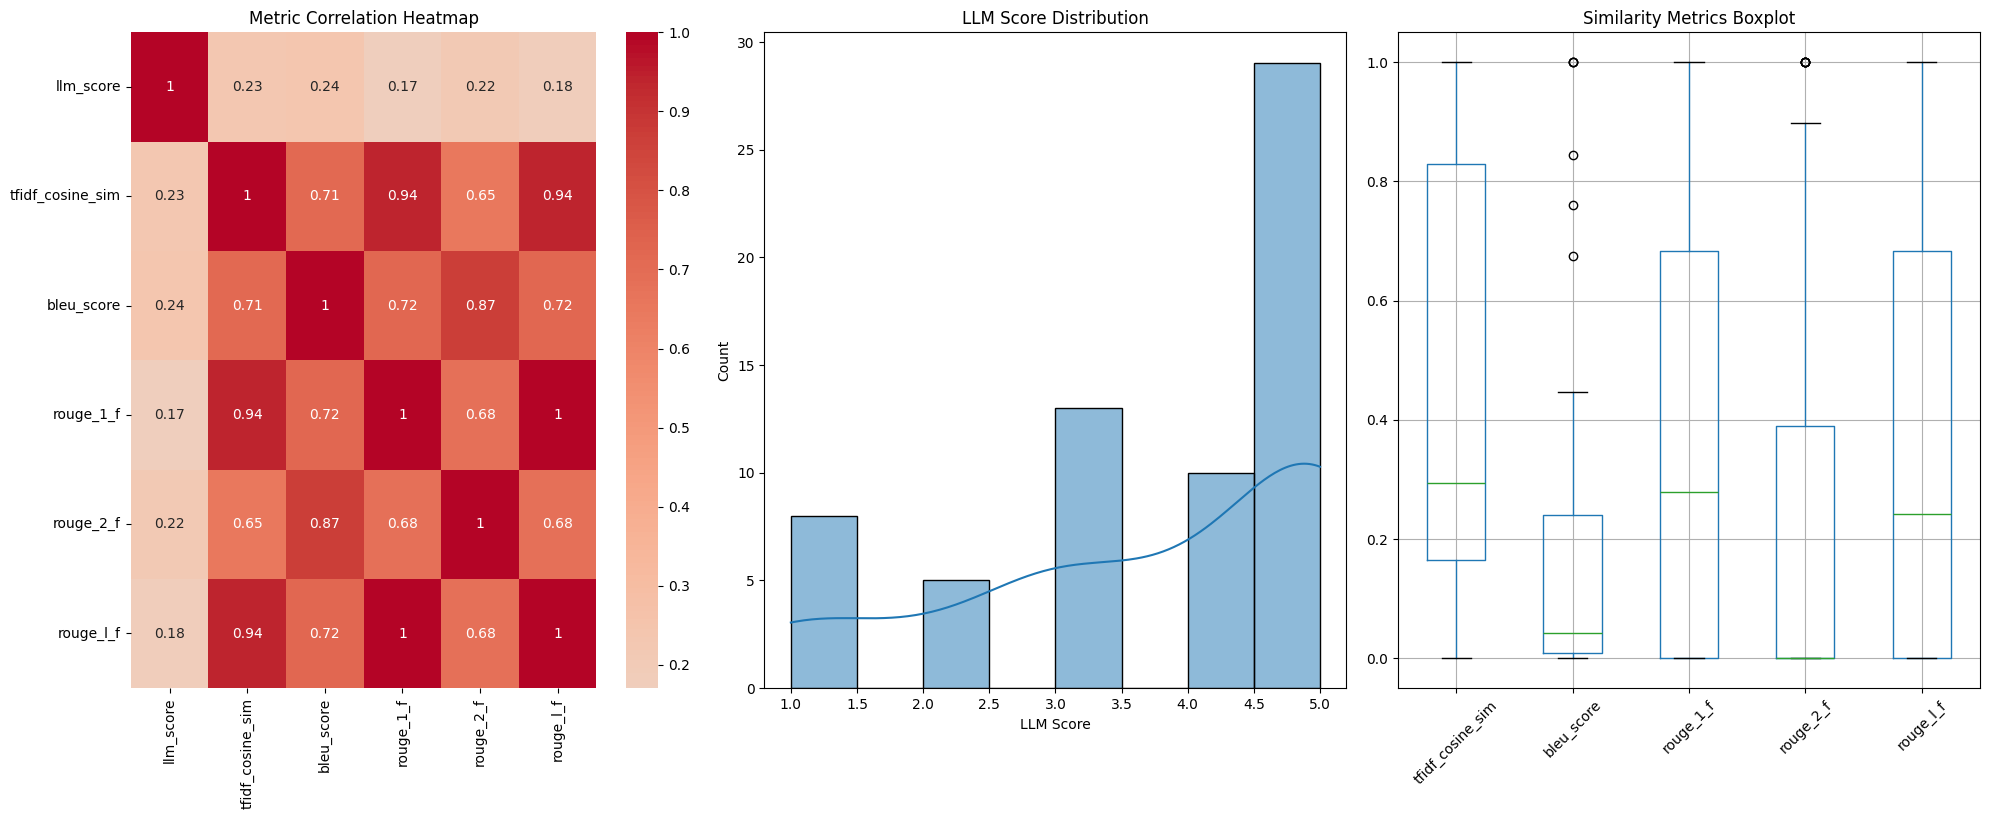

In [104]:
# Now Lets Run Metrics And Check Visualizations.
# Load JSON File.
results = []

with open(file='complete_evals.json',mode="r") as f:
    results = json.load(f)

df = pd.DataFrame(results)
tfidf_vec = TfidfVectorizer()
rouge = Rouge()

metrics_df=compute_metrics(dataframe=df,tfidf_vectorizer=tfidf_vec,rouge=rouge)
visualize_metrics(metrics_df=metrics_df)